# Pre-training DelphBERT - A tiny Transformer model based on a large newspaper dataset

* //TODO: Copy description of project from Github
* //TODO: Description of data 

In [5]:
import glob
import os
from pathlib import Path

from typing import Any, Dict, List, NamedTuple, Optional, Sequence, Tuple, Union

from tokenizers import Tokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from transformers import RobertaConfig
from transformers import RobertaTokenizerFast
from transformers import BertTokenizer
from transformers import PreTrainedTokenizer
from transformers import TrainingArguments
from transformers import RobertaForMaskedLM
from datasets import Dataset, DatasetDict

import torch
from torch import Tensor
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

## Load Data

First, we need to load the entire "processed" library of Delpher newspaper on the transformer.

* // TODO: even though we are loading clean and unclean text, we are training using the **unclean** text, as Transformers want complete sentences and the clean text does not have stopwords nor lower-upper cases.
    * Think testing the performance training on semi-clean text

In [6]:
PATH_RAW_FILES = "/home/leonardovida/data-histaware/raw/raw_merged/"
PATH_TOKENIZER_DIR = "/home/leonardovida/dev/hist-aware/notebooks/models/bert-training-from-scratch/tokenizer"
PATH_DATASET_DIR = "/home/leonardovida/dev/hist-aware/notebooks/models/bert-training-from-scratch/dataset"

# For tokenizer
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#!mkdir PATH_MODEL_DIR

## Load data into Dataset directly from .csv

In [7]:
import datasets

csv_paths = [str(x) for x in Path(PATH_RAW_FILES).glob("*.csv")]
dataset = datasets.load_dataset(
    "csv",
    data_files = csv_paths
)

Using custom data configuration default-1765ec5baa25fcb6
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-1765ec5baa25fcb6/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Remove columns that are not necessary in the training

In [8]:
dataset = dataset.remove_columns(['Unnamed: 0', 'article_name', 'date', 'index_article',
                                  'article_filepath', 'dir', 'title', 'access_rights',
                                  'identifier', 'metadata_title', 'index_metadata', 'metadata_filepath',
                                  'newspaper_title', 'newspaper_date', 'newspaper_publisher', 'newspaper_source',
                                  'newspaper_volume', 'newspaper_issuenumber', 'newspaper_recordIdentifier',
                                  'transformedRecordIdentifier'])

In [9]:
dataset = dataset.filter(lambda article: article['subject'] == "artikel")

Loading cached processed dataset at /home/leonardovida/.cache/huggingface/datasets/csv/default-1765ec5baa25fcb6/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0/cache-8a85db9cb5d9cb6e.arrow


### Look at one example

Always visually check to understand if dataset is actually what you expect

In [10]:
dataset["train"]["p"][1]

'[\'TIMMERMAN Arme Feenstra hat it op it heden moai drok. Dy drokte hat syn moaije kanten, mar ek syn listige. Men kin troch de drokte de klanten net sa gau helpe as men wol woe en .de klanten wurde wolris hwat üngedurich en komme to freegjen: „Hwa.nnear sil it nou wêze? Komme jo nou hast ek ris?" Frou Heerschop fan Tsjalhuzum forwachtte de timmerman ek al in skoft. Okkerwyks lei der by him in brief fan har troch de bus. Dêr stie yn: Mattheüs 11:3. De famylje Feenstra fansels hastich de tekst yn \\\'e bibel opsykje en hwat stie dêr: „Zijt gij het, die komen zou, of hebben wij een ander te verwachten?\\\'\\\' Der is in brief werom gien mei in sitaet fan Don Herold: „Werken is het mooiste wat er is. \\\'Laten we dus altijd zorgen, dat we iets voor de volgende dag overlaten. („Nijslan" — Nijland). *\']'

In [11]:
import re
import nltk

def paragraph_clean(article):
    """Basic cleaning of paragraphs.
    
    More can and will be done in the tokenizing step.
    """
    words = " ".join([w for w in nltk.word_tokenize(article["p"])])
    words = "".join([re.sub(r"[^-0-9\w,. ?!()%/]", r"", w) for w in words])
    words = re.sub(r"^\s*|\s\s*", " ", words).strip()
    return {"p": words}
    
dataset = dataset.map(paragraph_clean, num_proc=9)

In [12]:
dataset["train"]["p"][1]

'TIMMERMAN Arme Feenstra hat it op it heden moai drok . Dy drokte hat syn moaije kanten , mar ek syn listige . Men kin troch de drokte de klanten net sa gau helpe as men wol woe en .de klanten wurde wolris hwat üngedurich en komme to freegjen Hwa.nnear sil it nou wêze ? Komme jo nou hast ek ris ? Frou Heerschop fan Tsjalhuzum forwachtte de timmerman ek al in skoft . Okkerwyks lei der by him in brief fan har troch de bus . Dêr stie yn Mattheüs 113 . De famylje Feenstra fansels hastich de tekst yn e bibel opsykje en hwat stie dêr Zijt gij het , die komen zou , of hebben wij een ander te verwachten ? Der is in brief werom gien mei in sitaet fan Don Herold Werken is het mooiste wat er is . Laten we dus altijd zorgen , dat we iets voor de volgende dag overlaten . ( Nijslan Nijland ) .'

### Divide each paragraph into sentences

In [ ]:
import re
#from nltk.tokenize import sent_tokenize

def sentence_tokenize(article):
    """Tokenize sentences from paragraphs."""
    sents = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)(\s|[A-Z].*)', article["p"])
    return {"sentences": sents}

dataset = dataset.map(sentence_tokenize, num_proc=9)

In [ ]:
dataset["train"]["sentences"][1]

Check for sentences

In [ ]:
dataset.features

### Check distribution of paragraph lengths

Use pre-trained tokenizer to tokenize individual sentences. We do this to check for the length of each individual sentence and understand how much data we will lose when truncating on pre-training (the maximum length of BERT is 512 tokens). 

We also want to understand the overall distribution of the sentences and check how many short sentences there are in the dataset. We will put a bottom and top limit for each article

In [11]:
from transformers import BertTokenizer

def build_dist(article):
    token_lens = []
    for sent in article["sentences"]:
        tokens = tokenizer.encode(sent, max_length=512, truncation=True)
        token_lens.append(len(tokens))
    return {"sentences_lengths": token_lens}

In [19]:
dataset = dataset.map(build_dist, num_proc=8)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [4]:
len(dataset["train"]["p_lengths"])

KeyError: "Column p_lengths not in the dataset. Current columns in the dataset: ['Unnamed: 0', 'article_name', 'date', 'index_article', 'article_filepath', 'dir', 'title', 'p', 'subject', 'access_rights', 'recordIdentifier', 'identifier', 'metadata_title', 'index_metadata', 'metadata_filepath', 'newspaper_title', 'newspaper_date', 'newspaper_publisher', 'newspaper_source', 'newspaper_volume', 'newspaper_issuenumber', 'newspaper_recordIdentifier', 'transformedRecordIdentifier']"

/home/leonardovida/.cache/pypoetry/virtualenvs/histaware-NidRwJ64-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


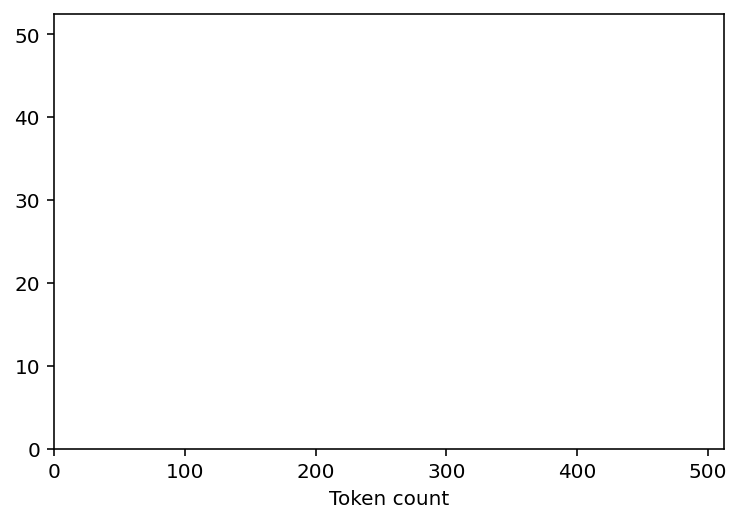

In [24]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

sns.distplot(dataset["train"]["p_lengths"])
plt.xlim([0, 512]);
plt.xlabel('Token count');

### Rebuild from sentences to shorter paragraphs

In [ ]:
def unite(sentences, n):
    """Unite sentences previously split using nltk.tokenize."""
    count = [0]
    sents = []
    for sent in sentences:
        if sum(count) + len(sent.split()) > 400:
            return sents
        else:
            sents.append(sent)
            count.append(len(sent.split()))

dataset = dataset.map(unite, num_proc=8)

Split into train, test and validation and save

In [ ]:
# Split 90% train
train_testvalid = dataset.train_test_split(test_size=0.1)
# Split valid into 50% valid and 50% test
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
# Gather everything into dataset
datasets = DatasetDict({
    "train": train_testvalid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]})

In [ ]:
dataset.save_to_disk(PATH_DATASET_DIR)

---